### **Importación de librerías**

In [1]:
import tensorflow as tf
import cv2
import os
import numpy as np
from keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import random

### **Montar acceso a Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Descomprimir dataset**

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/datasets/DEF.zip' -d '/content/drive/MyDrive/Colab Notebooks/datasets/'

### **Ruta del dataset**

In [3]:
ruta_del_dataset = '/content/drive/MyDrive/Colab Notebooks/Datasets/DEF'

In [4]:
# Obtener la lista de carpetas en la ruta del dataset
carpetas = os.listdir(ruta_del_dataset)

# Recorrer cada carpeta y contar el número de archivos de imagen en cada una
for carpeta in carpetas:
    ruta_carpeta = os.path.join(ruta_del_dataset, carpeta)
    if os.path.isdir(ruta_carpeta):  # Verificar si es un directorio
        archivos = os.listdir(ruta_carpeta)
        num_imagenes = len([archivo for archivo in archivos if archivo.endswith(('.jpg', '.jpeg', '.png'))])
        print(f"En la carpeta '{carpeta}' hay {num_imagenes} imágenes.")

En la carpeta '1' hay 1002 imágenes.
En la carpeta '2' hay 1002 imágenes.
En la carpeta '3' hay 1002 imágenes.
En la carpeta '4' hay 1002 imágenes.
En la carpeta '5' hay 1002 imágenes.
En la carpeta '0' hay 1002 imágenes.


### **Visualización del dataset**

In [5]:
def mostrar_imagenes_en_carpeta(carpeta, titulo):
    plt.figure(figsize=(10, 10))

    imagenes = os.listdir(carpeta)
    num_imagenes_a_mostrar = min(len(imagenes), 5)

    filas = 5
    columnas = 5

    for i, nombreimg in enumerate(imagenes[:num_imagenes_a_mostrar]):
        plt.subplot(filas, columnas, i + 1)
        imagen = mpimg.imread(os.path.join(carpeta, nombreimg))

        # Verificar si la imagen ya está en escala de grises
        if len(imagen.shape) == 2 or imagen.shape[-1] == 1:
            plt.imshow(imagen, cmap='gray')
        else:
            plt.imshow(imagen)

        plt.title(titulo)
        plt.axis('off')

    plt.show()

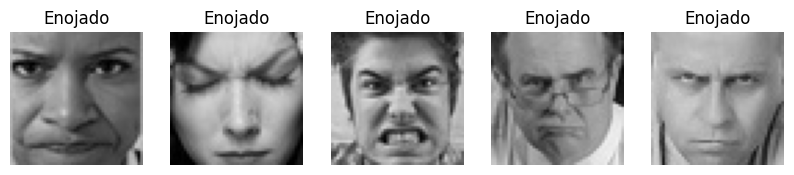

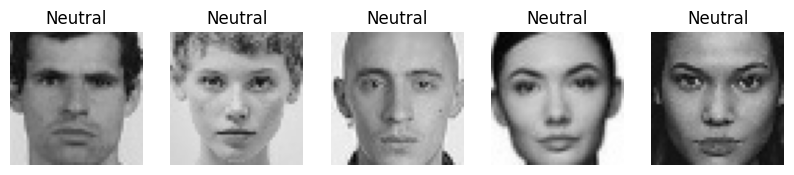

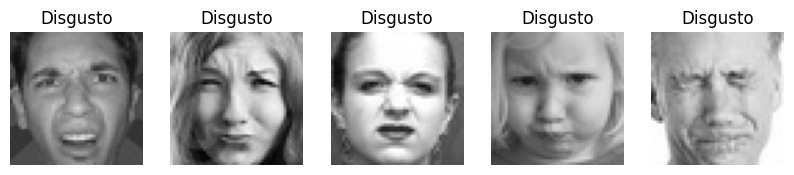

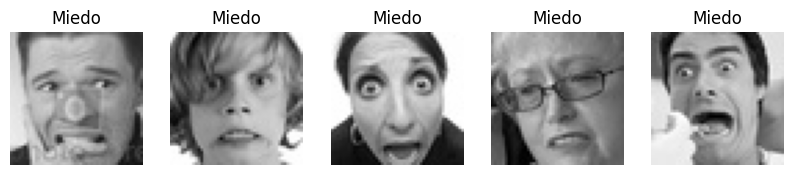

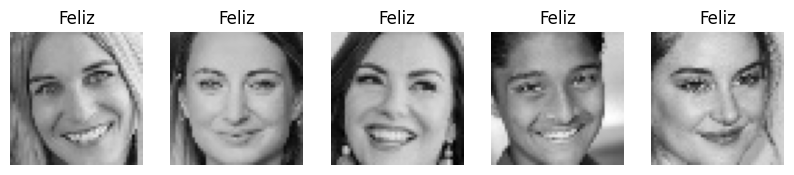

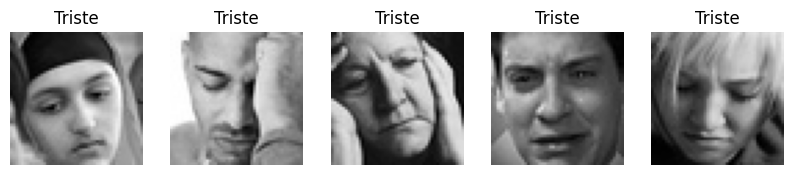

In [6]:
mostrar_imagenes_en_carpeta("/content/drive/MyDrive/Colab Notebooks/Datasets/DEF-Original/0", "Enojado")
mostrar_imagenes_en_carpeta("/content/drive/MyDrive/Colab Notebooks/Datasets/DEF-Original/1", "Neutral")
mostrar_imagenes_en_carpeta("/content/drive/MyDrive/Colab Notebooks/Datasets/DEF-Original/2", "Disgusto")
mostrar_imagenes_en_carpeta("/content/drive/MyDrive/Colab Notebooks/Datasets/DEF-Original/3", "Miedo")
mostrar_imagenes_en_carpeta("/content/drive/MyDrive/Colab Notebooks/Datasets/DEF-Original/4", "Feliz")
mostrar_imagenes_en_carpeta("/content/drive/MyDrive/Colab Notebooks/Datasets/DEF-Original/5", "Triste")

### **Carga de Imágenes y Etiquetas para Procesamiento**

In [7]:
tamaño_img = 48

In [8]:
# Listas para almacenar imágenes (X) y etiquetas (y)
X = []
y = []

# Carga de imágenes y etiquetas
for categoría in os.listdir(ruta_del_dataset):
    ruta_categoría = os.path.join(ruta_del_dataset, categoría)
    número_clase = int(categoría)

    for archivo_img in os.listdir(ruta_categoría):
        ruta_img = os.path.join(ruta_categoría, archivo_img)

        # Cargar la imagen y convertirla a escala de grises
        img = cv2.imread(ruta_img, cv2.IMREAD_GRAYSCALE)

        # Redimensionar la imagen
        img = cv2.resize(img, (tamaño_img, tamaño_img))

        # Añadir la imagen y la etiqueta a las listas X e y
        X.append(img)
        y.append(número_clase)

In [9]:
# Convertir las listas en arrays de NumPy
X = np.array(X)
y = np.array(y)

### **División de Conjuntos: Entrenamiento, Validación y Prueba, y Preprocesamiento de Datos**

In [10]:
# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_entrenamiento, X_temporal, y_entrenamiento, y_temporal = train_test_split(X, y, test_size=0.3, random_state=42)
X_validacion, X_prueba, y_validacion, y_prueba = train_test_split(X_temporal, y_temporal, test_size=0.5, random_state=42)

In [11]:
# Reconfigurar X para que tenga la forma (num_muestras, altura, ancho, canales)
X_entrenamiento = X_entrenamiento.reshape(-1, 48, 48, 1)
X_validacion = X_validacion.reshape(-1, 48, 48, 1)
X_prueba = X_prueba.reshape(-1, 48, 48, 1)

In [12]:
# Normalizar los datos
X_entrenamiento = X_entrenamiento / 255.0
X_validacion = X_validacion / 255.0
X_prueba = X_prueba / 255.0

### **Aumento de Datos**

In [13]:
# Configuración del aumento de datos
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [14]:
datagen.fit(X_entrenamiento)

### **Arquitectura del modelo CNN**

In [91]:
modelo = models.Sequential([

    tf.keras.layers.BatchNormalization(input_shape=(48, 48, 1)),

    tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(512, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(6, activation="softmax")
])

In [69]:
modelo.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_9 (Bat  (None, 48, 48, 1)         4         
 chNormalization)                                                
                                                                 
 conv2d_61 (Conv2D)          (None, 48, 48, 128)       1280      
                                                                 
 conv2d_62 (Conv2D)          (None, 48, 48, 128)       147584    
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 24, 24, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_43 (Dropout)        (None, 24, 24, 128)       0         
                                                                 
 conv2d_63 (Conv2D)          (None, 24, 24, 128)      

### **Configuración del Optimizador y Compilación del Modelo**

In [70]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
modelo.compile(optimizer=opt,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

### **Entrenamiento del Modelo**

In [71]:
historial = modelo.fit(datagen.flow(X_entrenamiento, y_entrenamiento, batch_size=32),
                       epochs=100,
                       validation_data=(X_validacion, y_validacion))

Epoch 1/100
132/132 [==============================] - 11s 54ms/step - loss: 7.5564 - accuracy: 0.1882 - val_loss: 5.0542 - val_accuracy: 0.2350
Epoch 2/100
132/132 [==============================] - 6s 45ms/step - loss: 3.8275 - accuracy: 0.2227 - val_loss: 2.9589 - val_accuracy: 0.2051
Epoch 3/100
132/132 [==============================] - 6s 47ms/step - loss: 2.5224 - accuracy: 0.2277 - val_loss: 2.2007 - val_accuracy: 0.2350
Epoch 4/100
132/132 [==============================] - 6s 44ms/step - loss: 2.0602 - accuracy: 0.2388 - val_loss: 1.9061 - val_accuracy: 0.2894
Epoch 5/100
132/132 [==============================] - 6s 48ms/step - loss: 1.8719 - accuracy: 0.2676 - val_loss: 1.7589 - val_accuracy: 0.2993
Epoch 6/100
132/132 [==============================] - 6s 46ms/step - loss: 1.7895 - accuracy: 0.2771 - val_loss: 1.6764 - val_accuracy: 0.3758
Epoch 7/100
132/132 [==============================] - 6s 44ms/step - loss: 1.7372 - accuracy: 0.2978 - val_loss: 1.6346 - val_accuracy

In [85]:
nombre_modelo = "DEF.h5"
modelo.save(nombre_modelo)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **Evaluación del Modelo**


In [72]:
modelo.evaluate(X_prueba, y_prueba)

29/29 [==============================] - 0s 14ms/step - loss: 0.4297 - accuracy: 0.8980


[0.4297075569629669, 0.898004412651062]

**Matriz de Confusión**

29/29 [==============================] - 0s 13ms/step


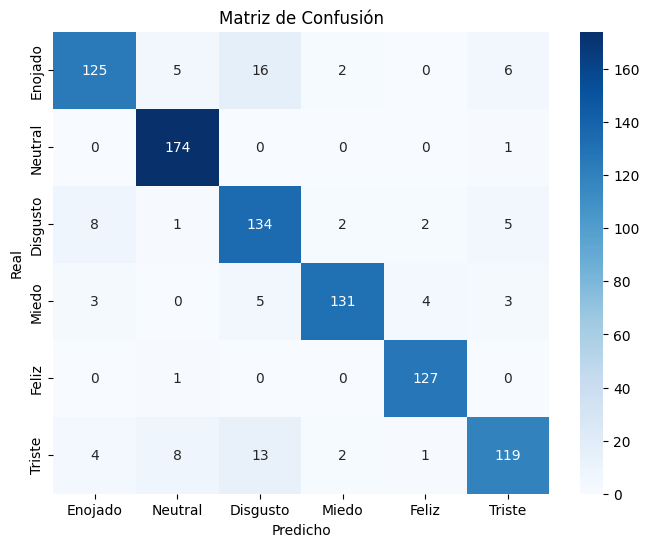

In [90]:
# Obtener las predicciones del modelo en el conjunto de prueba
predicciones_y = modelo.predict(X_prueba)

# Convertir las predicciones a etiquetas numéricas
etiquetas_predichas_y = np.argmax(predicciones_y, axis=1)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_prueba, etiquetas_predichas_y)

# Definir las etiquetas de clase
etiquetas_clase = ['Enojado', 'Neutral', 'Disgusto', 'Miedo', 'Feliz', 'Triste']

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas_clase, yticklabels=etiquetas_clase)
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

**Visualización de imágenes mal calificadas**

5/5 [==============================] - 0s 16ms/step


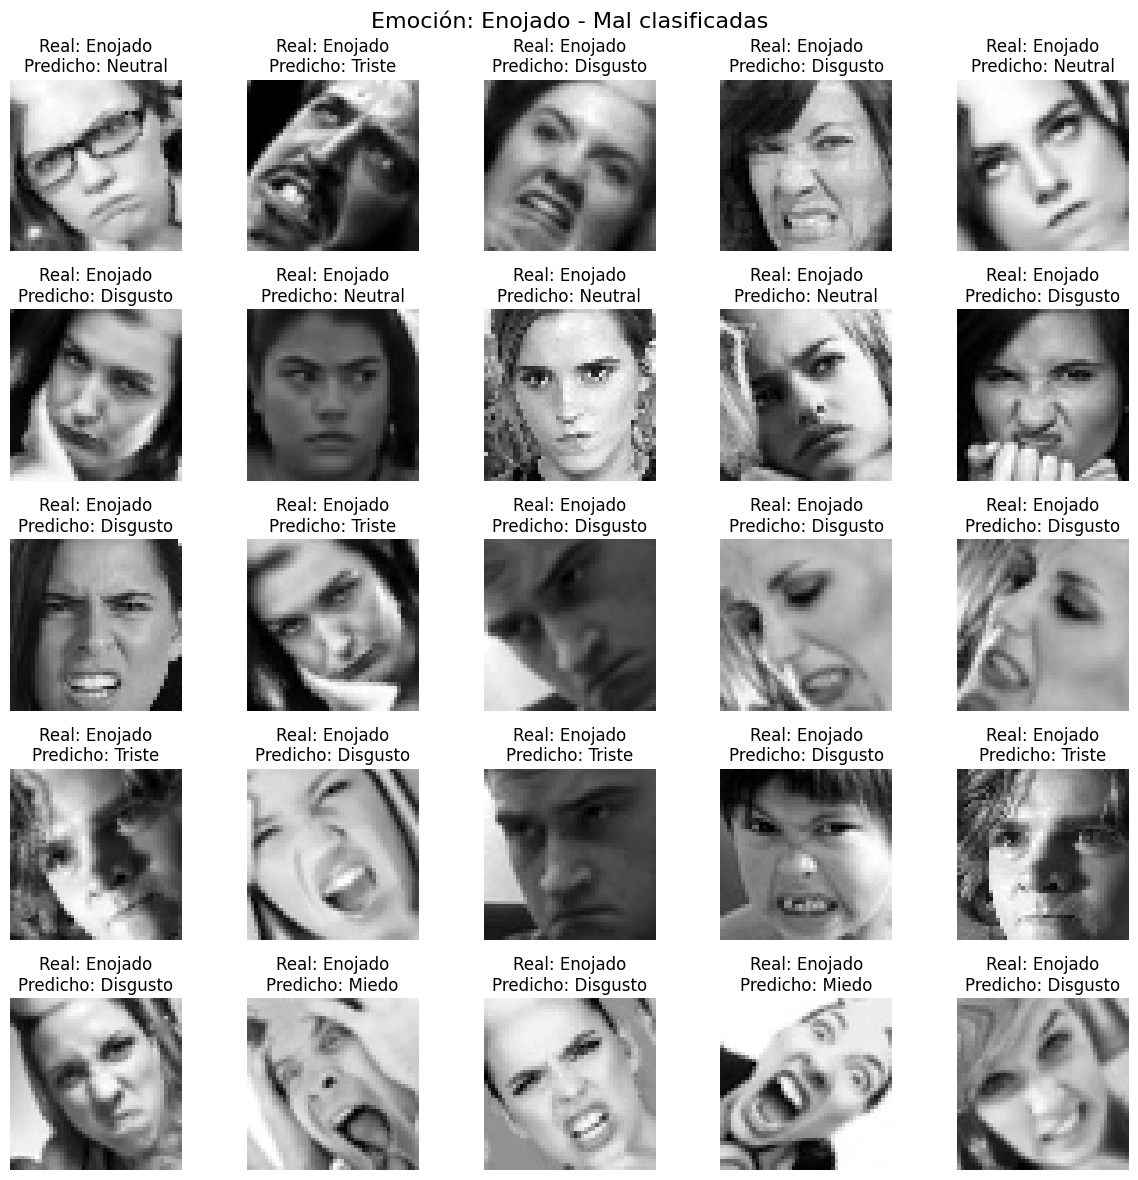

6/6 [==============================] - 0s 14ms/step


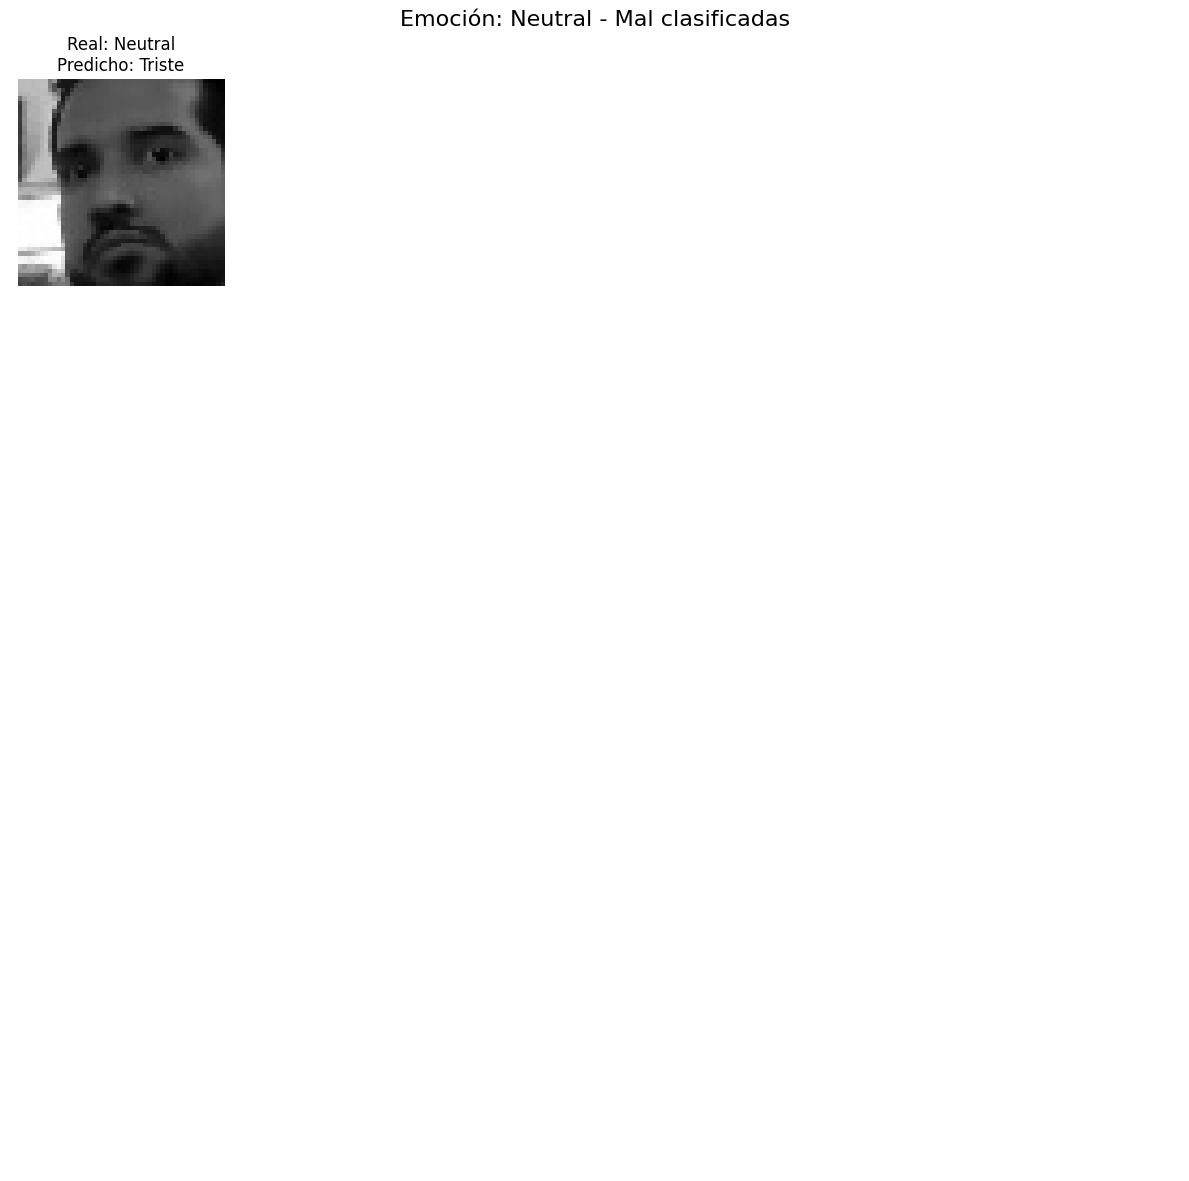

5/5 [==============================] - 0s 14ms/step


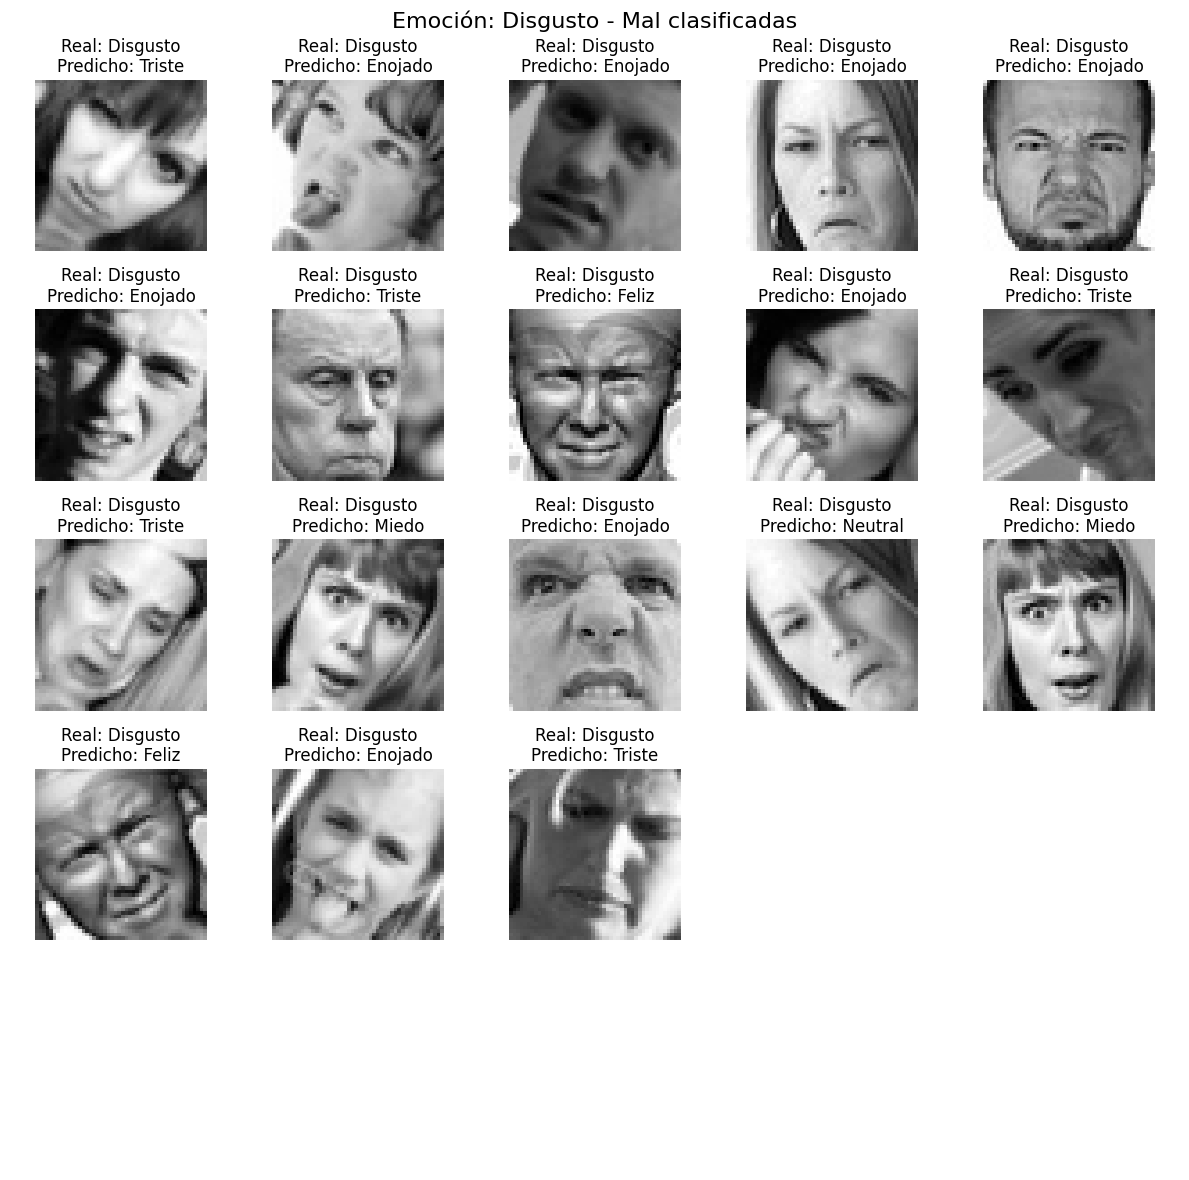

5/5 [==============================] - 0s 14ms/step


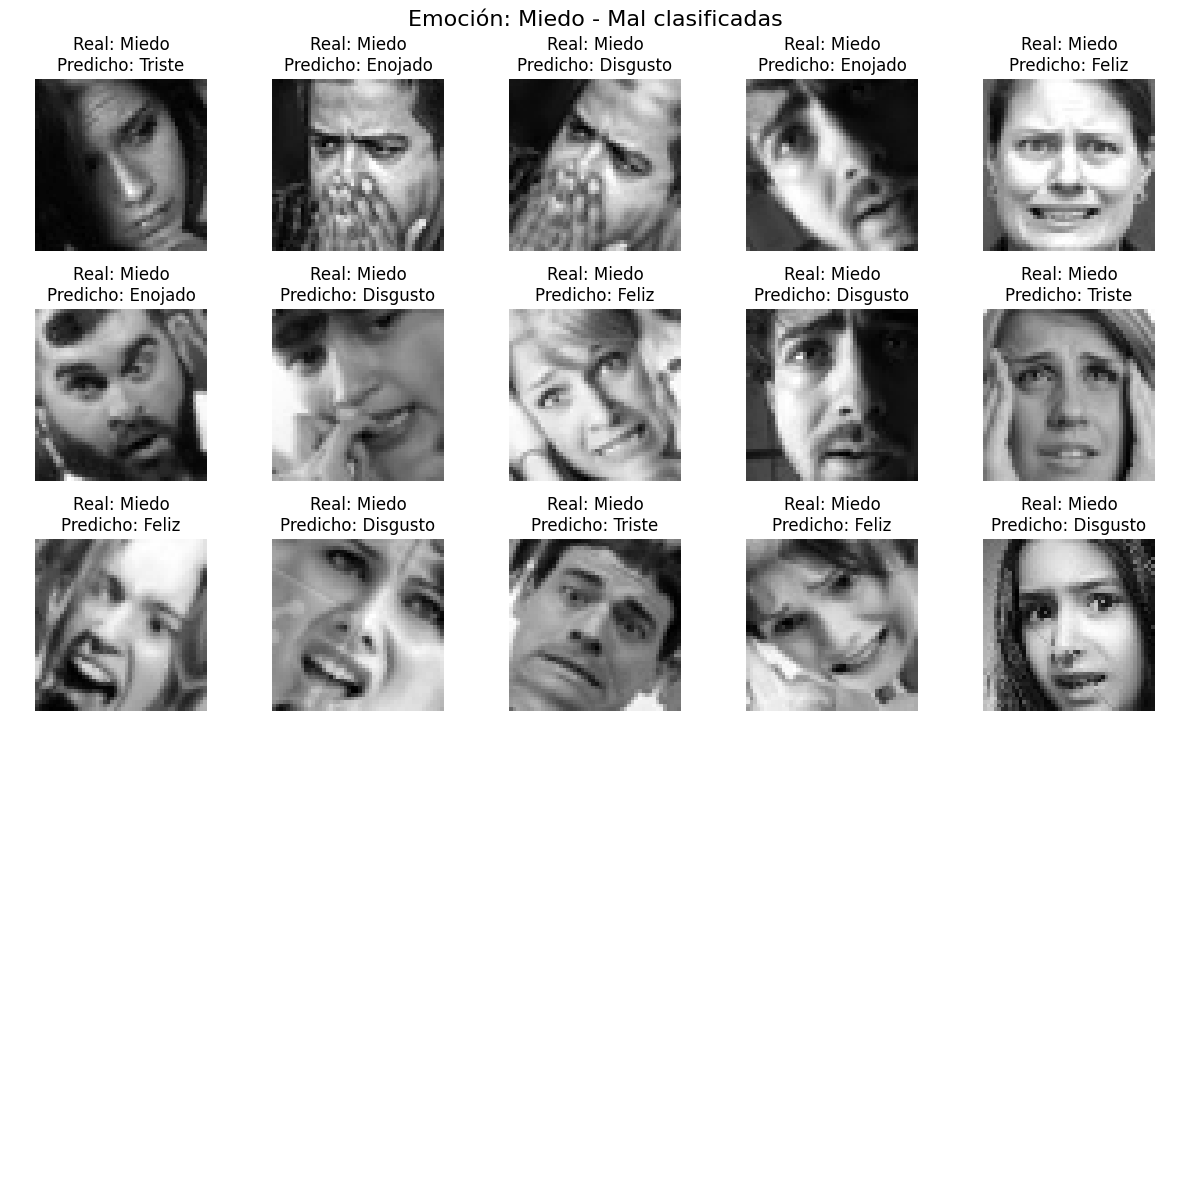

4/4 [==============================] - 0s 14ms/step


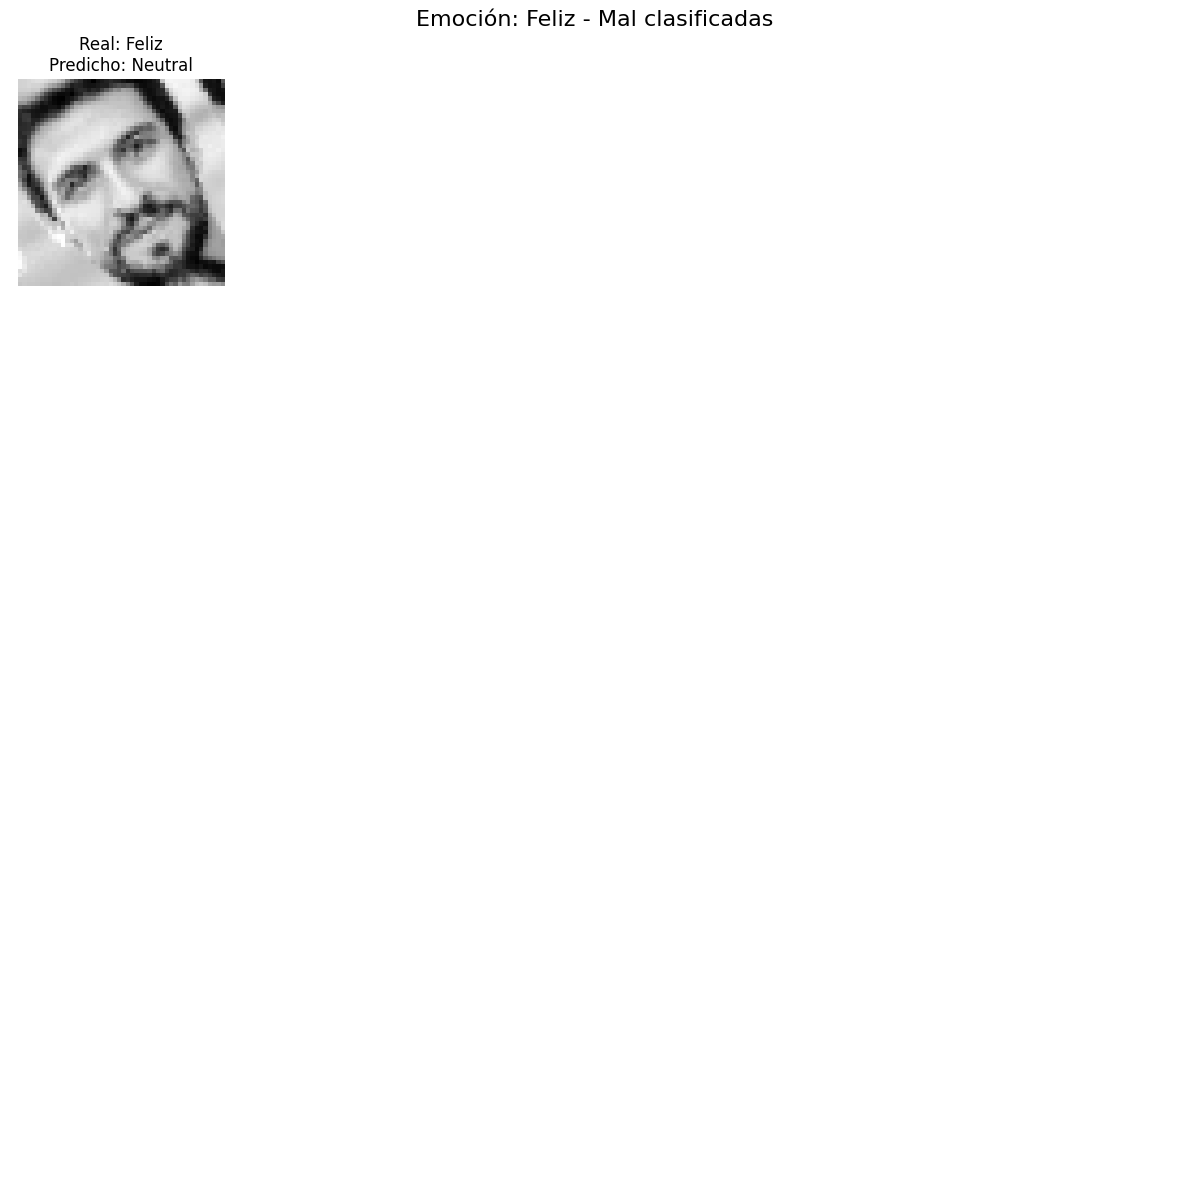

5/5 [==============================] - 0s 14ms/step


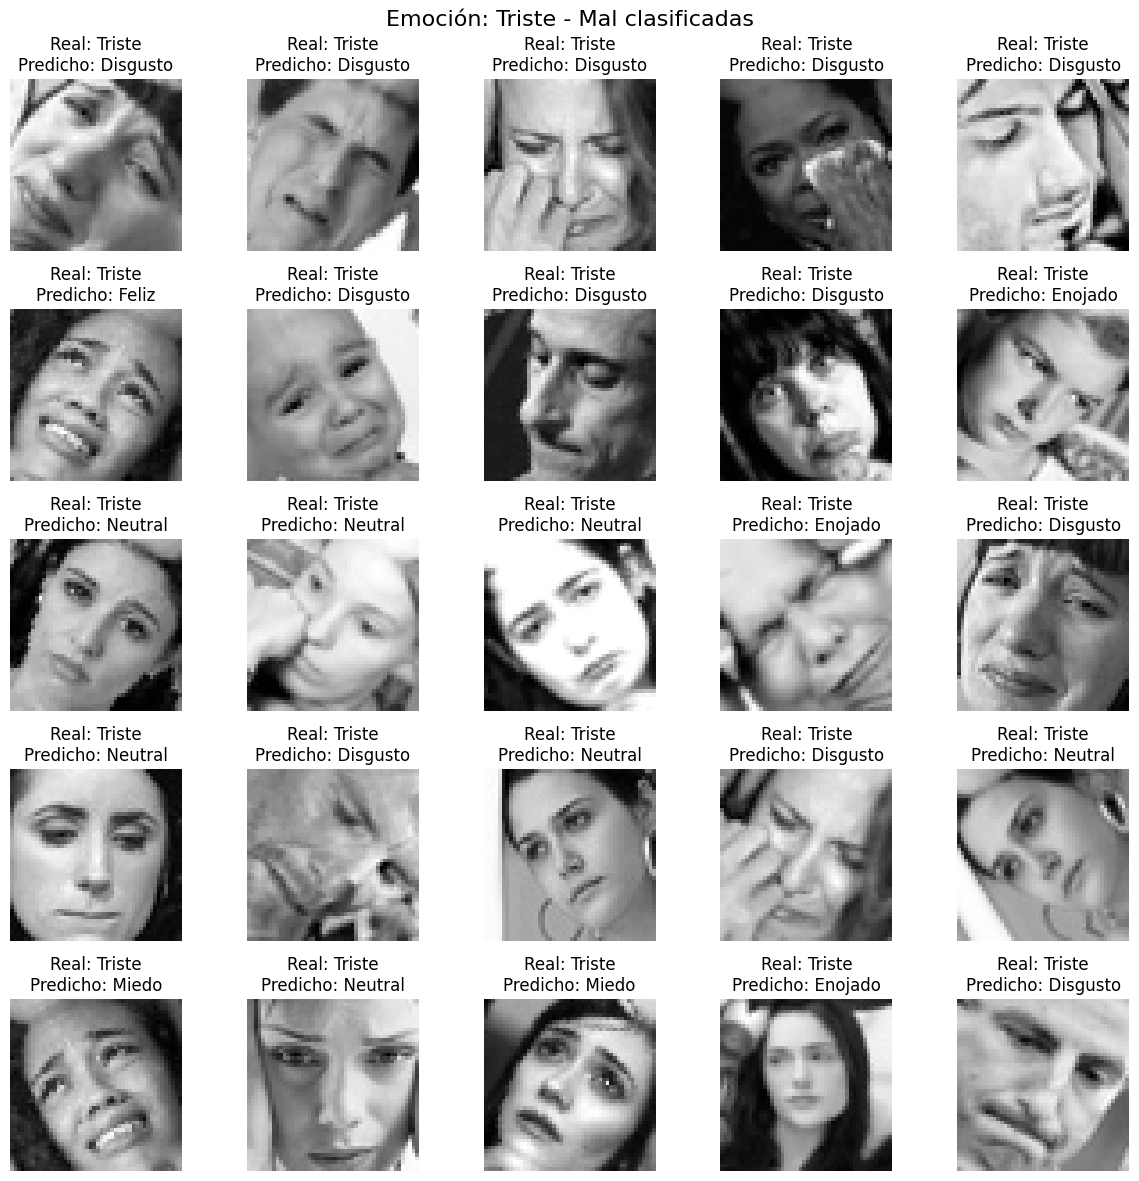

In [80]:
def mostrar_imagenes_incorrectas_por_emocion(emocion, imagenes_emocion, etiquetas_emocion, etiquetas_predichas_emocion, num_filas=5, num_columnas=5):
    fig, axs = plt.subplots(num_filas, num_columnas, figsize=(12, 12))
    fig.suptitle(f'Emoción: {etiquetas_clase[emocion]} - Mal clasificadas', fontsize=16)

    mal_clasificadas = np.where(etiquetas_emocion != etiquetas_predichas_emocion)[0]
    contador_imagenes = 0

    for i in range(num_filas):
        for j in range(num_columnas):
            if contador_imagenes < len(mal_clasificadas):
                index = mal_clasificadas[contador_imagenes]
                axs[i, j].imshow(imagenes_emocion[index].squeeze(), cmap='gray')
                axs[i, j].set_title(f'Real: {etiquetas_clase[etiquetas_emocion[index]]}\n'
                                    f'Predicho: {etiquetas_clase[etiquetas_predichas_emocion[index]]}')
                axs[i, j].axis('off')
                contador_imagenes += 1
            else:
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Mostrar solo las imágenes mal clasificadas
for emocion in range(6):
    # Filtrar las imágenes por cada emoción en el conjunto de prueba
    indices_emocion = np.where(y_prueba == emocion)[0]
    imagenes_emocion = X_prueba[indices_emocion]
    etiquetas_emocion = y_prueba[indices_emocion]

    # Obtener las predicciones para las imágenes de esta emoción
    predicciones_emocion = modelo.predict(imagenes_emocion)
    etiquetas_predichas_emocion = np.argmax(predicciones_emocion, axis=1)

    mostrar_imagenes_incorrectas_por_emocion(emocion, imagenes_emocion, etiquetas_emocion, etiquetas_predichas_emocion)

**Métricas de Rendimiento**

In [92]:
accuracy = accuracy_score(y_prueba, etiquetas_predichas_y)
precision = precision_score(y_prueba, etiquetas_predichas_y, average='weighted')
recall = recall_score(y_prueba, etiquetas_predichas_y, average='weighted')
f1 = f1_score(y_prueba, etiquetas_predichas_y, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

print("\nReporte de clasificación:")
print(classification_report(y_prueba, etiquetas_predichas_y))

Accuracy: 0.8980044345898004
Precision: 0.8994603710870162
Recall: 0.8980044345898004
F1 Score: 0.8972539824061154

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       154
           1       0.92      0.99      0.96       175
           2       0.80      0.88      0.84       152
           3       0.96      0.90      0.93       146
           4       0.95      0.99      0.97       128
           5       0.89      0.81      0.85       147

    accuracy                           0.90       902
   macro avg       0.90      0.90      0.90       902
weighted avg       0.90      0.90      0.90       902



**Visualización de la Pérdida en Entrenamiento y Validación a lo largo de las Épocas**

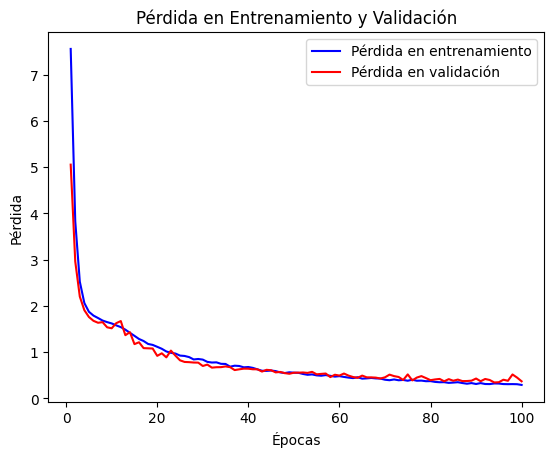

In [93]:
# Obtener datos de pérdida del historial
pérdida_entrenamiento = historial.history['loss']
pérdida_validación = historial.history['val_loss']

# Crear un rango para el número de épocas
épocas = range(1, len(pérdida_entrenamiento) + 1)

# Graficar la pérdida en el conjunto de entrenamiento y validación
plt.plot(épocas, pérdida_entrenamiento, 'b', label='Pérdida en entrenamiento')
plt.plot(épocas, pérdida_validación, 'r', label='Pérdida en validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

**Visualización de la Precisión en Entrenamiento y Validación a lo largo de las Épocas**

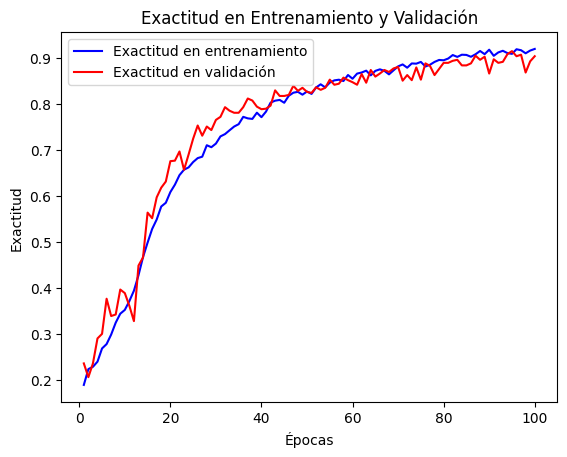

In [94]:
# Obtener datos de precisión del historial
exactitud_entrenamiento = historial.history['accuracy']
exactitud_validacion = historial.history['val_accuracy']

# Crear un rango para el número de épocas
epocas = range(1, len(exactitud_entrenamiento) + 1)

# Graficar la precisión en el conjunto de entrenamiento y validación
plt.plot(epocas, exactitud_entrenamiento, 'b', label='Exactitud en entrenamiento')
plt.plot(epocas, exactitud_validacion, 'r', label='Exactitud en validación')
plt.title('Exactitud en Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()
plt.show()

### **Visualización de Activaciones**

1/1 [==============================] - 0s 89ms/step


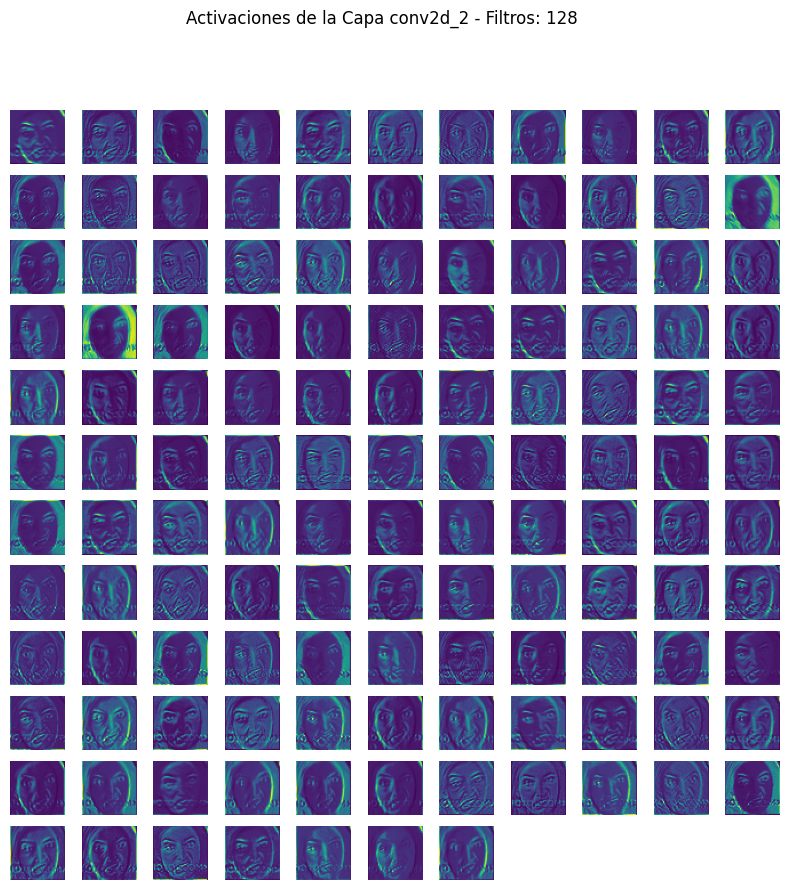

1/1 [==============================] - 0s 104ms/step


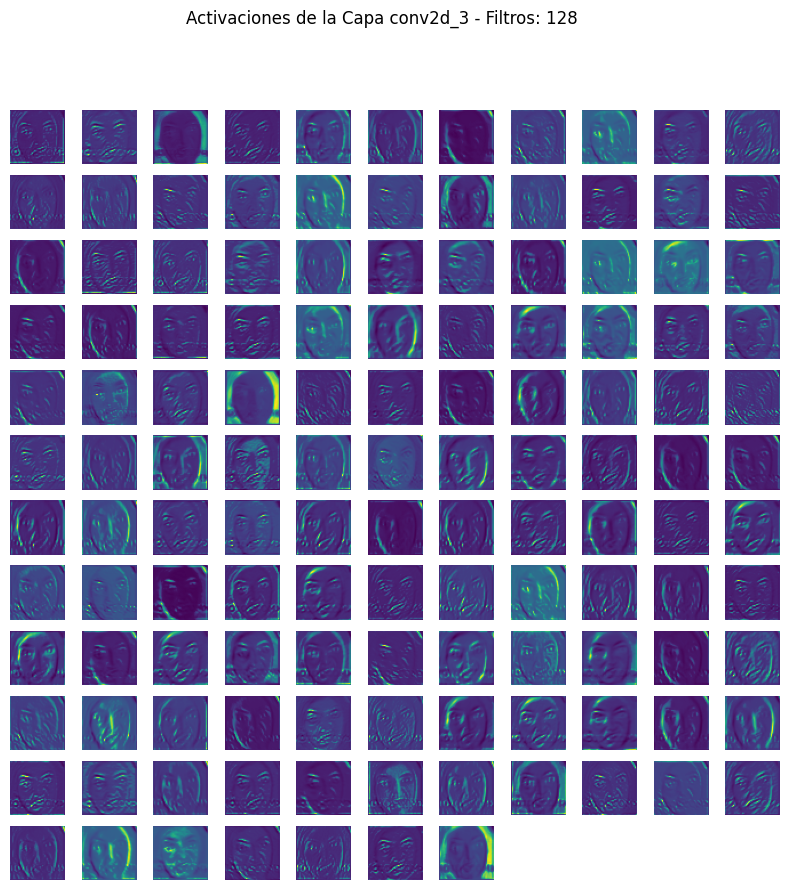

1/1 [==============================] - 0s 111ms/step


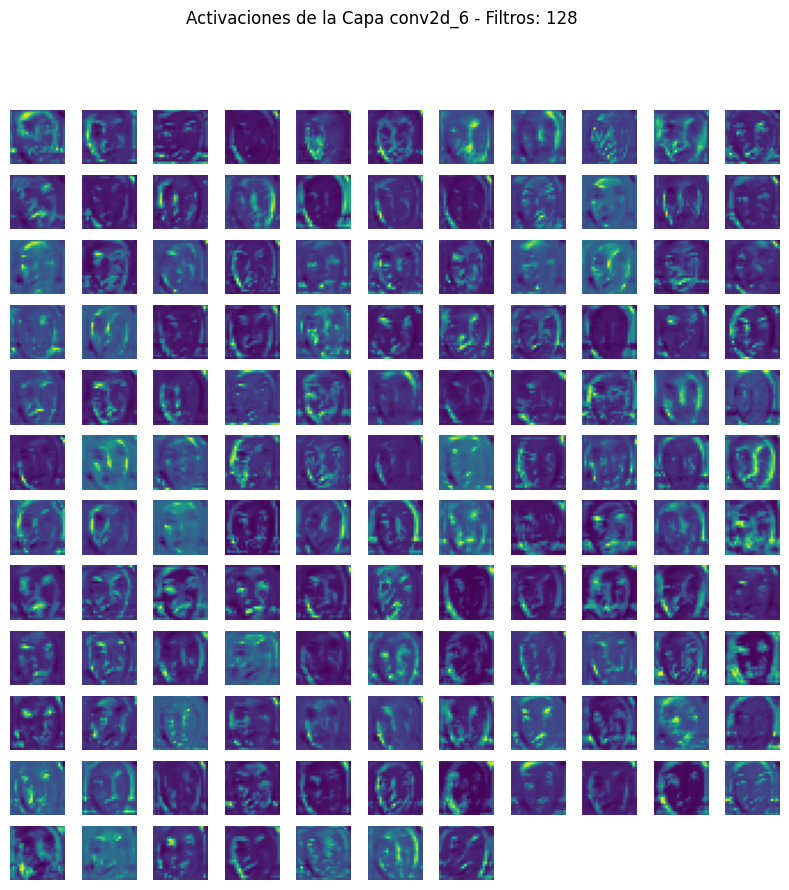

1/1 [==============================] - 0s 128ms/step


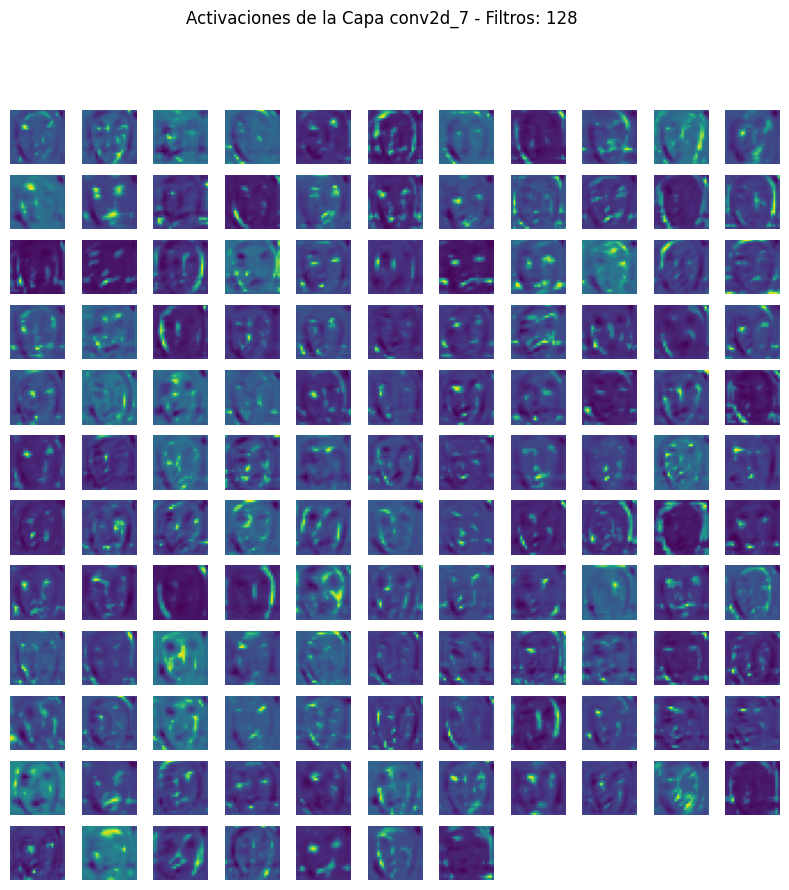

1/1 [==============================] - 0s 148ms/step


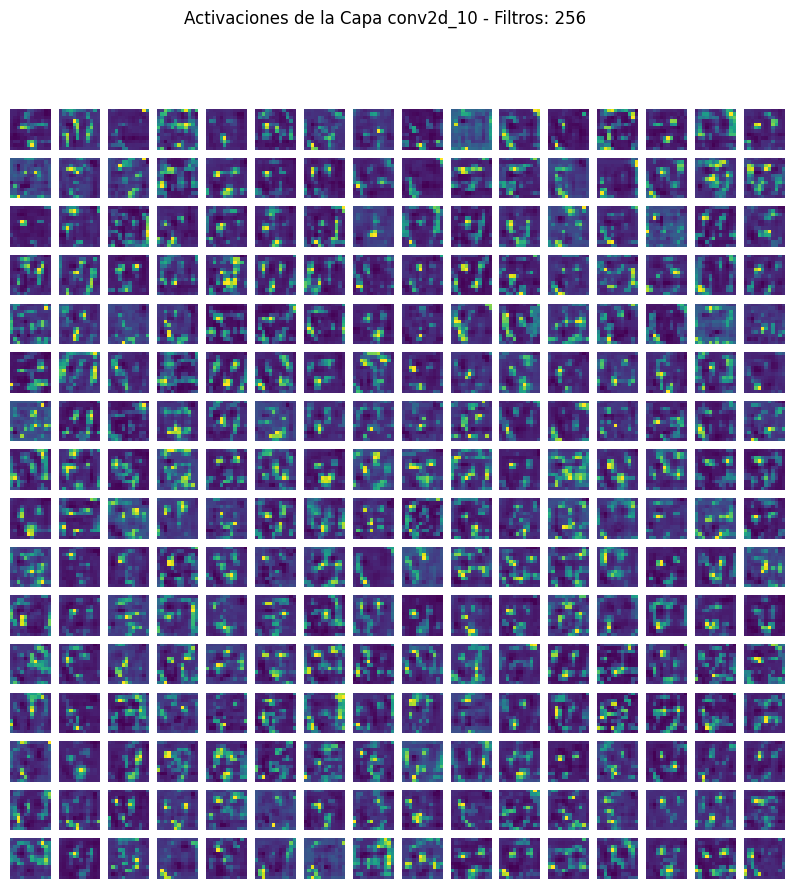

1/1 [==============================] - 0s 119ms/step


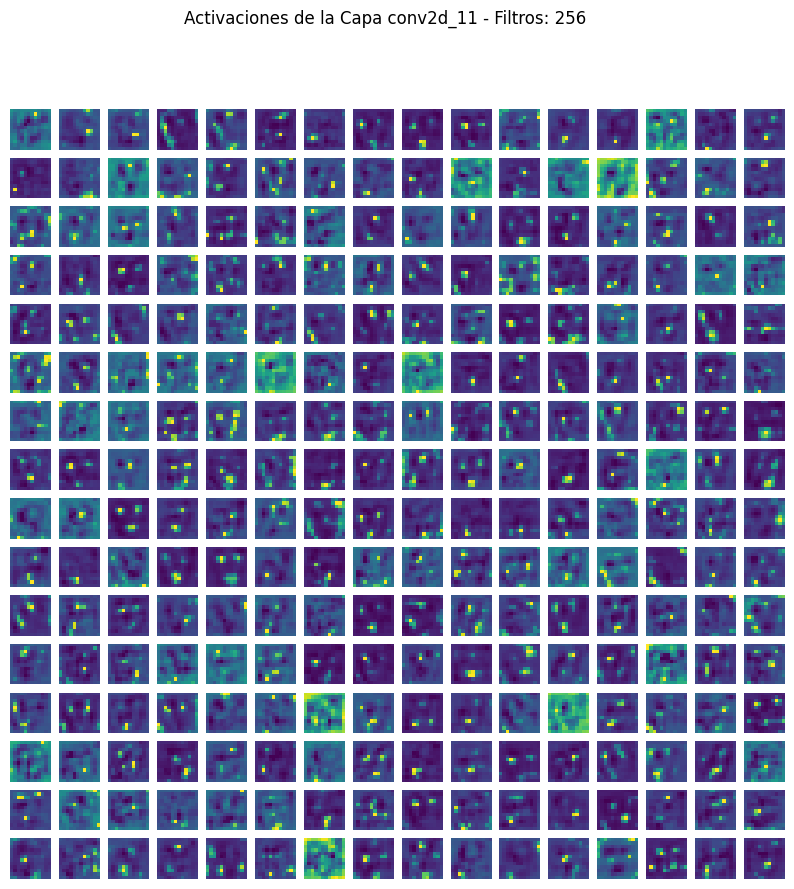

1/1 [==============================] - 0s 200ms/step


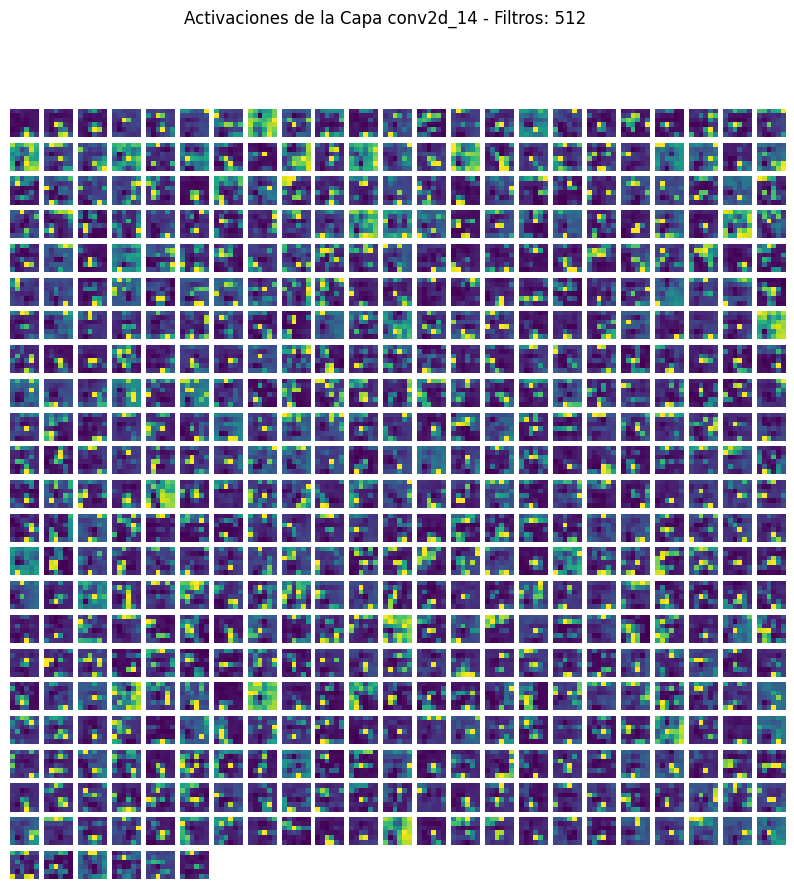

1/1 [==============================] - 0s 184ms/step


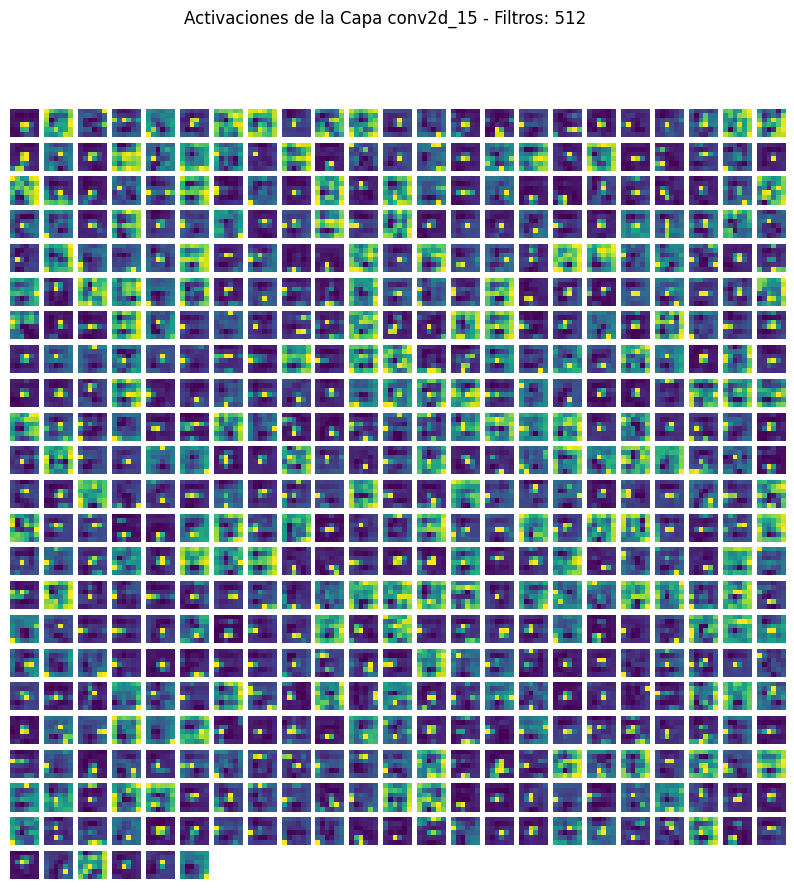

In [89]:
from tensorflow.keras.models import Model

# Visualizar las activaciones de todas las capas convolucionales y mostrarlas
for i, capa in enumerate(modelo.layers):
    if isinstance(capa, tf.keras.layers.Conv2D):  # Verificar si la capa es Conv2D

        nombre_capa = f"conv2d_{i + 1}"
        filtros = capa.output.shape[-1]  # Obtener el número de filtros de la capa

        # Crear un modelo que devuelve las activaciones de esta capa para una entrada dada
        modelo_capa = Model(inputs=modelo.input, outputs=capa.output)

        imagen_muestra = X_prueba[1]
        imagen_muestra = np.expand_dims(imagen_muestra, axis=0)

        # Obtener las activaciones para la imagen seleccionada en esta capa
        activaciones = modelo_capa.predict(imagen_muestra)

        # Calcular el diseño del gráfico basado en el número de filtros
        filas = int(np.ceil(np.sqrt(filtros)))
        columnas = int(np.ceil(filtros / filas))

        # Visualizar las activaciones de esta capa
        plt.figure(figsize=(10, 10))
        for j in range(filtros):
            plt.subplot(filas, columnas, j + 1)  # Ajustar el diseño del gráfico
            plt.imshow(activaciones[0, :, :, j], cmap='viridis')  # Mostrar la activación del filtro 'j'
            plt.axis('off')
        plt.suptitle(f'Activaciones de la Capa {nombre_capa} - Filtros: {filtros}')  # Título general para la visualización
        plt.show()